# Enganando uma rede neural com o Fast Gradient Sign Method (FGSM)

Neste artigo irei abordar como gerar um exemplo de adversário usando o ataque Fast Gradient Sign Method (FGSM), um tipo de ataque capaz de enganar uma rede neural e prejudicar o processo de classificação.

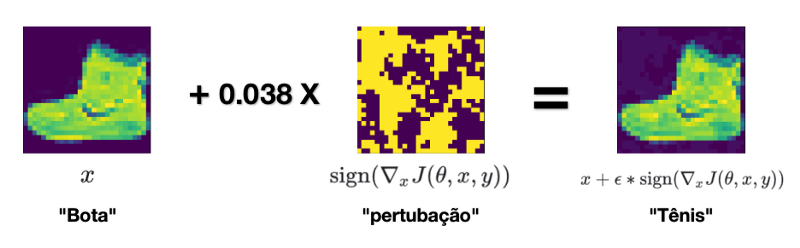

## O que é um exemplo de adversário?
Um exemplo de adversários são entradas especializadas criadas com o propósito de confundir uma rede neural e atrapalhar o processo de classificação, capazes de gerar uma classificação errada com um alto grau de confiança pela rede. Ao alterar a entrada original com pequenas perturbações que para o olho humano se tornam indistinguíveis, a rede neural fica vulnerável e acaba entendendo que a entrada em questão pertence a uma classe que muitas vezes nem mesmo lembra a classe verdadeira da entrada.

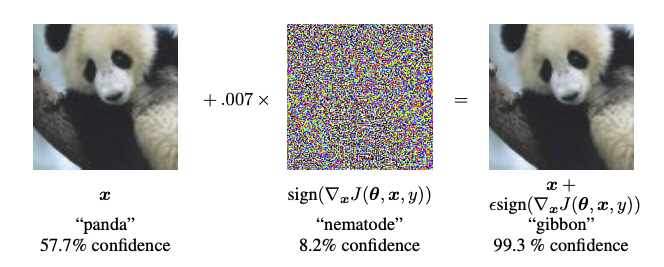

Existem vários tipos de ataques onde pode-se burlar o processo de classificação de uma rede neural, no entanto, irei focar no ataque de método de sinal de gradiente rápido, um ataque de caixa branca cujo objetivo é garantir apenas uma classificação incorreta. Para ser mais direto, esse tipo de ataque se caracteriza quando o invasor tem acesso completo ao modelo que está sendo atacado, algo que na prática não é muito viável mas não deixa de ser algo interessante.

## Preparando o ambiente
Ao decorrer deste artigo, irei abordar os principais trechos de código que permitem um entendimento sobre o conceito e aplicabilidade do estudo. O código completo estarei disponibilizando no GitHub junto de um Jupyter notebook, no entanto, os requisitos para executar são os seguintes:
- Python 3.8
- Ambiente Anaconda
- Jupyter Notebook
- TensorFlow

## Importando as bibliotecas necessárias para o projeto
Para realizarmos o carregamento correto da nossa rede neural com o Keras, precisamos importar algumas bibliotecas essenciais para a construção da nossa rede e algumas outras bibliotecas que nos ajudarão a ter uma melhor visualização e manipulação dos dados. O código abaixo realiza as importações necessárias:

In [1]:
# TensorFlow e tf.keras
import tensorflow as tf
from tensorflow import keras
# Bibliotecas auxiliares
import numpy as np
import matplotlib.pyplot as plt
# Verificamos se a importação foi realizada
print(tf.__version__)

2.5.0


## Montando o estudo de caso
Primeiro vamos escolher o estudo de caso que vamos abordar. Para facilitar o entendimento vou optar por escolher um classificador que utiliza como dataset o Fashion MNIST, este classificador ja foi abordado em outro artigo anteriormente e vou utilizá-lo para dar sequência ao nosso estudo.

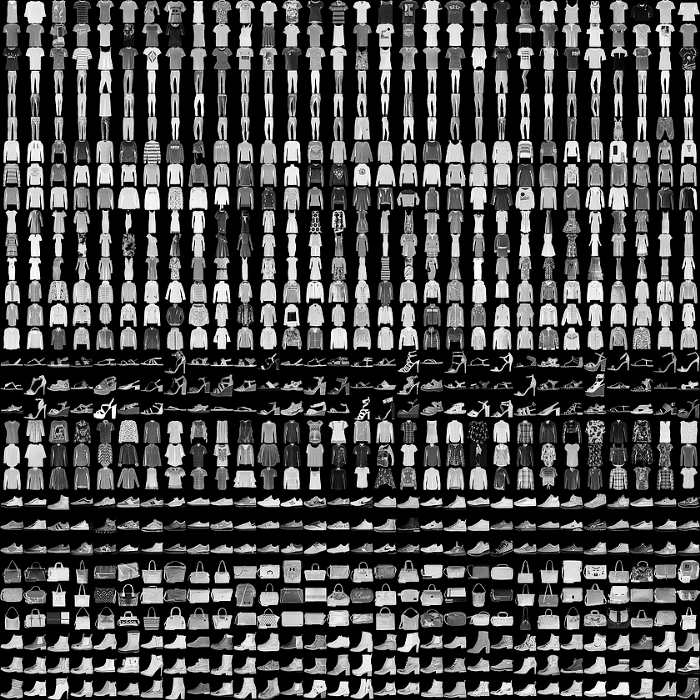

Não entrarei em muitos detalhes sobre a rede que estamos utilizando pois a mesma já foi detalhada em um artigo passado. Iniciamos carregando o modelo que foi treinado anteriormente.

In [2]:
modelo = tf.keras.models.load_model('meu_modelo')
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


## Carregando o dataset
Vamos importar e carregar a base Fashion MNIST diretamente do TensorFlow para utilizarmos como nosso dataset, para isso vamos instanciar uma variável conhecida como “fashion_mnist” que irá conter um objeto que vai nos permitir carregar a base de dados para podermos manipulá-la. Em seguida vamos utilizar o método .load_data() para poder carregar os dados e separá-los em dois grupos: um grupo com 10.000 imagens para teste e um outro grupo com 60.000 imagens para treinamento:

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(imagens_treinamento, imagens_treinamento_labels), (imagens_teste, imagens_teste_labels) = fashion_mnist.load_data()

Com o Keras a manipulação de dados se torna mais simplificada, no código acima conseguimos carregar de uma base de dados pronta cerca de mais de 60.000 imagens e separá-las em grupos de teste e treinamento, além dos seus respectivos labels, sem nenhuma dificuldade. Vamos brincar um pouco com a nossa base de dados e visualizar algum elemento da mesma escolhendo aleatoriamente um número entre 0 59.999, no exemplo abaixo vamos visualizar o segundo ítem da nossa base de treinamento:

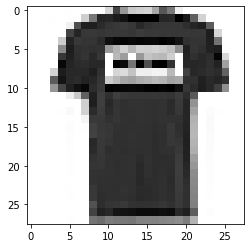

In [4]:
plt.imshow(imagens_treinamento[1],cmap=plt.cm.binary,)
plt.show()

As imagens caregadas são arrays NumPy de tamanho 28x28, com os valores des pixels entre 0 to 255, estes valores precisam ser ajustados para uma margem menor como entre 0 e 1 para que o nosso treinamento possa ser efetuado sem prejudicarmos o desempenho de nossa rede.

In [5]:
imagens_treinamento = imagens_treinamento / 255.0
imagens_teste = imagens_teste / 255.0

Já os labels (alvo da classificação) são um array de inteiros, no intervalo de 0 a 9 e correspondentes a suas respectivas imagens. Prosseguimos definindo os nomes de cada classe a ser reconhecida pela nossa rede neural, temos um total de 10 classes com suas representações numéricas variando de 0 a 9.

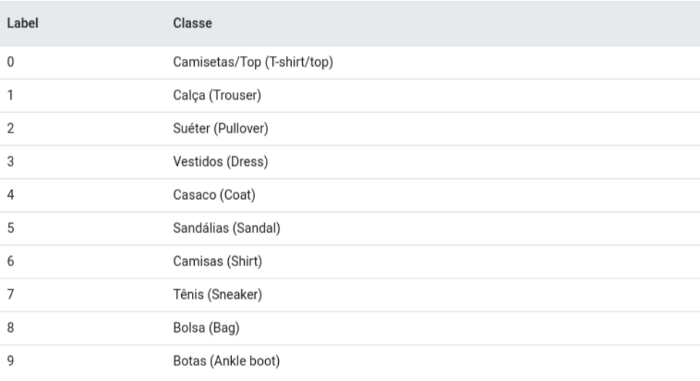

Esses nomes já foram pré-definidos inicialmente, o que acontece é que o nome das classes não são incluídas na base de dados e precisamos adicionálas manualmente:

In [6]:
nomes_das_classes = ['Camiseta/Top', 'Calça', 'Suéter', 'Vestido', 'Casaco', 'Sandália', 'Camisa', 'Tênis', 'Bolsa', 'Botas']

## Método de sinal de gradiente rápido
O método de sinal de gradiente rápido, ou Fast Gradient Sign Method (FGSM), basicamente utiliza os gradientes de perda da rede neural para gerar uma nova imagem que maximize a perda ao mesmo tempo em que é indistinguivel pelo olho humano se comparado a imagem original. Essa nova imagem é conhecida como imagem do adversário, capaz de passar de forma imperceptivel pelo olho humano ao mesmo tempo em que consegue enganar um modelo de rede neural já treinado.

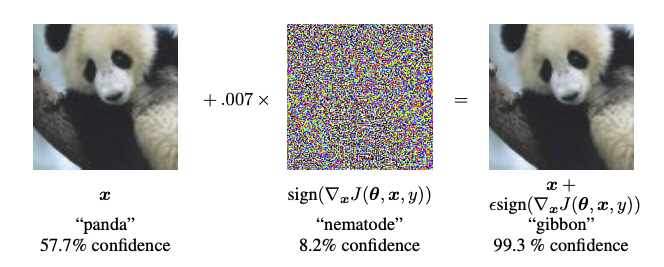

O método utiliza os gradientes da perda, a partir de uma imagem de entrada, a fim de criar uma nova imagem que maximize a perda e consequêntemente engane a rede neural treinada. Essa nova imagem é chamada de imagem do adversário, capaz de ser indistinguivel pelo olho humano em relação a imagem original. Conforme a propria documentação do TensorFlow sobre FGSM, o Fast Gradient Sign Method pode ser descrito por meio da seguinte equação:

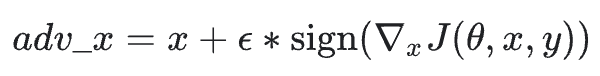

Onde:
- adv_x: equivale a imagem adversária.
- x: A imagem de entrada original.
- y: A etiqueta de entrada original.
- ε (epsilon): o multiplicador capaz de garantir que as perturbações sejam pequenas o suficiente para serem indistinguiveis pelo olho humano, quanto menor o valor menor o impacto na imagem gerada e menor a interferência aplicada.
- θ (theta): os parâmetros do modelo, basicamente o nosso modelo de rede neural.
- J: A função de perda.

A estratégia aplicada pelo FGSM nada mais é do que descobrir quanto cada pixel na imagem contribui para o valor de perda, permitindo a adição de uma perturbação proporcional capaz de manter a imagem a mais proxima da original. Outro ponto interessante é que uma vez que o modelo não está mais sendo treinado os parâmetros do modelo permanecem constantes e este tipo de ataque continua sendo bastante eficaz, enganando facilmente o modelo já treinado.

Não se assuste com essa parte, conforme formos avançando, por meio do codigo, ficará mais fácil compreender a formula e a sua aplicação.




## Implementando o método de sinal de gradiente rápido
Inicialmente devemos criar as perturbações que serão usadas para distorcer a imagem original, o que resultará em uma imagem adversária. Para gerarmos as perturbarções, vamos construir uma função que ficará responsável por nos retornar as perturbações geradas a partir de uma imagem utilizada como entrada.

In [7]:
def create_adversarial_pattern(input_image, input_label, model):
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
  with tf.GradientTape() as tape:
    image = tf.cast(input_image.reshape(1, 28, 28, 1), tf.float32)
    tape.watch(image)
    prediction = model(image)
    loss = loss_object(input_label, prediction)
#   # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, image)
#   # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

A função create_adversarial_pattern() recebe alguns parâmetros importantes:
- input_image: A imagem original a ser utilizada como entrada e que desejamos utilizar para gerar o erro na classificação.
- input_label: O label da classe verdadeira a qual a imagem de entrada pertence.
- model: O modelo treinado e carregado previamente.

O que a função basicamente faz é instruir o TensorFlow a registrar nossos gradientes ao mesmo tempo em que instrui explicitamente que desejamos rastrear as atualizações de gradientes em nossa entrada enquanto a predição é realizada. A partir do modelo e da imagem de entrada, obtemos a perda por meio da função de perda escolhida e definida previamente.

O proximo passo da nossa função será obter os gradientes em relação aos dados de perda e a imagem original por meio da função tape.gradient(). Finalizamos obtendo a nossa pertubação ou sinal do gradiente (signed_grad) contendo um vetor preenchido com valores 1 (positivo), 0 ou -1 (negativo), daí a origem do termo Fast Gradient Sign Method. 

## Implementando a geração da imagem adversaria
O passo seguinte será definir uma função que utilizará a pertubação gerada junto da imagem original para gerar uma imagem capaz de enganar a rede neural treinada sem modificar suas principais características. Chamaremos a função de generate_image_adversary():

In [8]:
def generate_image_adversary(image, perturbation, epsilon):
    with tf.GradientTape() as tape:
        image = tf.cast(image.reshape(1, 28, 28, 1), tf.float32)
    adversary = (image + (perturbation * epsilon)).numpy()
    return adversary

A função generate_image_adversary() recebe alguns parâmetros importantes:
- image: A imagem original a ser utilizada como entrada e que desejamos utilizar para gerar a imagem adversaria.
- perturbation: A pertubação obtida pela função create_adversarial_pattern().
- epsilon: o valor referente ao multiplicador capaz de garantir que as perturbações sejam pequenas o suficiente para serem indistinguiveis pelo olho humano

Esta função basicamente pegará nossa imagem e somará cada pixel a multiplicação dapertubação pelo valor de epsilon e retornará nossa imagem adversária. Observe o uso do metodo reshape() com os parâmetros 1, 28, 28 e 1 utilizado para adequar a imagem original as dimenções necessárias onde:
- 1: equivale a dimenção do lote (Batch dimension), por estaros trabalhando com apenas uma unica imagem, definimos o valor como 1.
- 28: A altura da imagem
- 28: O comprimento da imagem
- 1: O número de canais da imagem, no nosso caso as imagens possuem 1 canal apenas poe estarem na escala de cinza.

Uma dica interessante é experimentar diferentes valores de épsilon e observar a imagem resultante. Será possivel notar que conforme o valor do épsilon aumenta, fica mais fácil enganar a rede. E conforme diminui, mais dificil de enganar a rede se torna. Caracterizando como uma espécie de trade-off que resulta nas perturbações se tornando mais identificáveis ou não.


## Gerando a imagem adversária
Primeiro devemos gerar as perturbações que serão usadas para distorcer a imagem original, o que resultará em uma imagem adversária capaz de 'enganar' a rede neural já treinada. Para isso, utilizaremos o método create_adversarial_pattern(), passando como entrada uma imagem, o seu respectivo label e o modelo já treinado.

In [9]:
perturbacao = create_adversarial_pattern(imagens_treinamento[0], imagens_treinamento_labels[0],modelo )

O método create_adversarial_pattern() nos retornará os dados referentes as pertubações, utilizamos como base a primeira imagem do conjunto de treinamento de nosso dataset, esta imagem refere-se a uma bota conforme pode ser observado a seguir:



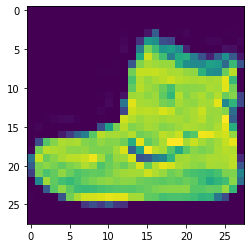

In [10]:
plt.imshow(imagens_treinamento[0])

O resultado das pertubações geradas pode ser visualizado abaixo:


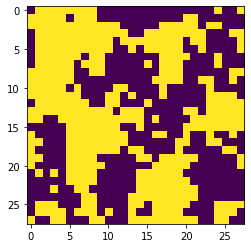

In [11]:
plt.imshow(perturbacao[0] * 0.5 + 0.5)
plt.show()

Apesar de interessante o resultado até este momento, ainda precisamos combinar os dados das pertubações com a imagem original sem que suas características principais se alterem drasticamente, tornando a imagem indistinguível ao olho humano ao mesmo tempo em que gera uma classificação errada pela rede neural já treinada. Prosseguimos com a geração da imagem adversário por meio do método generate_image_adversary(), passando como parâmetros a imagem original e a pertubação gerada anteriormente.

In [12]:
image_adversarial = generate_image_adversary(imagens_treinamento[0],perturbacao, 0.038)

Note que o valor para epsilon foi definido arbitrariamente como 0.038, quanto maior for este valor, maior será o impacto na imagem resultante, sendo sempre interessante encontrar um equilibrio para que a imagem não se distancie muito de suas características originais. O resultado final será uma imagem que se assemelha muito a original, passando desbercebido a olho humano.

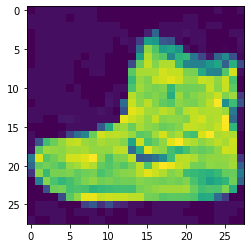

In [13]:
adversary = image_adversarial.reshape((28, 28)) * 255
adversary = np.clip(adversary, 0, 255).astype("uint8")
plt.imshow(adversary)
plt.show()

## Realizando as predições com a imagem original e a adversaria
Como exemplo para este artigo, foi utilizado uma imagem do conjunto de treinamento da rede, que após treinada é capaz de reconhecer as imagens com um grau elevado de precisão. Se colocarmos a rede treinada para indicar a qual classe a imagem original pertence teremos o resultado correto que é a classe 'Botas'.

Posição com maior probabilidade: 9

A imagem foi classificada como: Botas


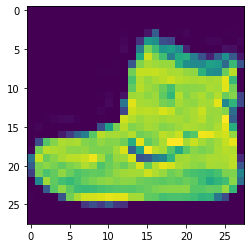

In [15]:
original_prediction = modelo.predict(imagens_treinamento[0].reshape(1, 28, 28, 1))
print("Posição com maior probabilidade: " +str(np.argmax(original_prediction)))
print("\nA imagem foi classificada como: "+ str(nomes_das_classes[np.argmax(original_prediction)]))
plt.imshow(imagens_treinamento[0])
plt.show()

Já a classificação da imagem adversária, gerada a partir das pertubações junto da imagem original, será diferente apesar de visualmente ambas as imagens apresentarem um alto grau de semelhança.

Posição com maior probabilidade: 7

A imagem foi classificada como: Tênis


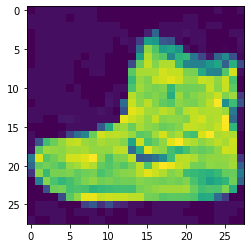

In [16]:
pred = modelo.predict(image_adversarial)
print("Posição com maior probabilidade: " +str(np.argmax(pred)))
print("\nA imagem foi classificada como: "+ str(nomes_das_classes[np.argmax(pred)]))
adversary = image_adversarial.reshape((28, 28)) * 255
adversary = np.clip(adversary, 0, 255).astype("uint8")
plt.imshow(adversary)
plt.show()

O resultado final pode ser comparado lado a lado a seguir, um teste interessante é alterar o valor de epsilon para ver os efeitos que são refletidos na imagem adversaria gerada e na classivifação.

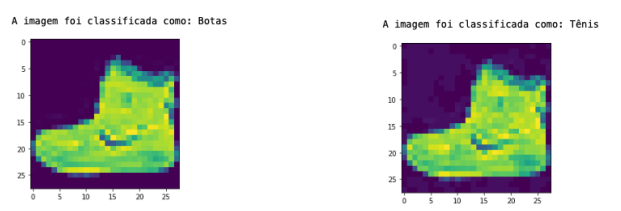

## Referências
- https://arxiv.org/abs/1412.6572
- https://www.pyimagesearch.com/2021/03/01/adversarial-attacks-with-fgsm-fast-gradient-sign-method/
- https://www.tensorflow.org/tutorials/generative/adversarial_fgsm
- https://medium.com/@RonaldLopes96/criando-uma-rede-neural-simples-com-o-keras-10e9dc268552
- https://medium.com/@RonaldLopes96/enganando-uma-rede-neural-com-o-fast-gradient-sign-method-fgsm-a1e0e854ceee